In [2]:
%pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 3.1 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 8.1 MB/s  0:00:04m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [umap-learn]4 [pynndescent]
Note: you may need to restart the kernel to use updated packages.


--- 🧠 Extracting high-dimensional latent features and spatial context ---
--- 📈 Validating predictive performance on 8409 urban nodes ---


/var/folders/jt/s5bg7p6n4mgfx_dznzr9hr7c0000gn/T/ipykernel_8313/2794873996.py:175: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=residual_df, x='City', y='Residual', palette='Spectral', ax=ax3, fliersize=1)
/var/folders/jt/s5bg7p6n4mgfx_dznzr9hr7c0000gn/T/ipykernel_8313/2794873996.py:178: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=20, ha='right')
/var/folders/jt/s5bg7p6n4mgfx_dznzr9hr7c0000gn/T/ipykernel_8313/2794873996.py:181: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


--- ✅ Research dashboard successfully saved to: /Users/oushilin/Desktop/Infor 301/final/Urban_Evolution_Analysis_Dashboard.png ---


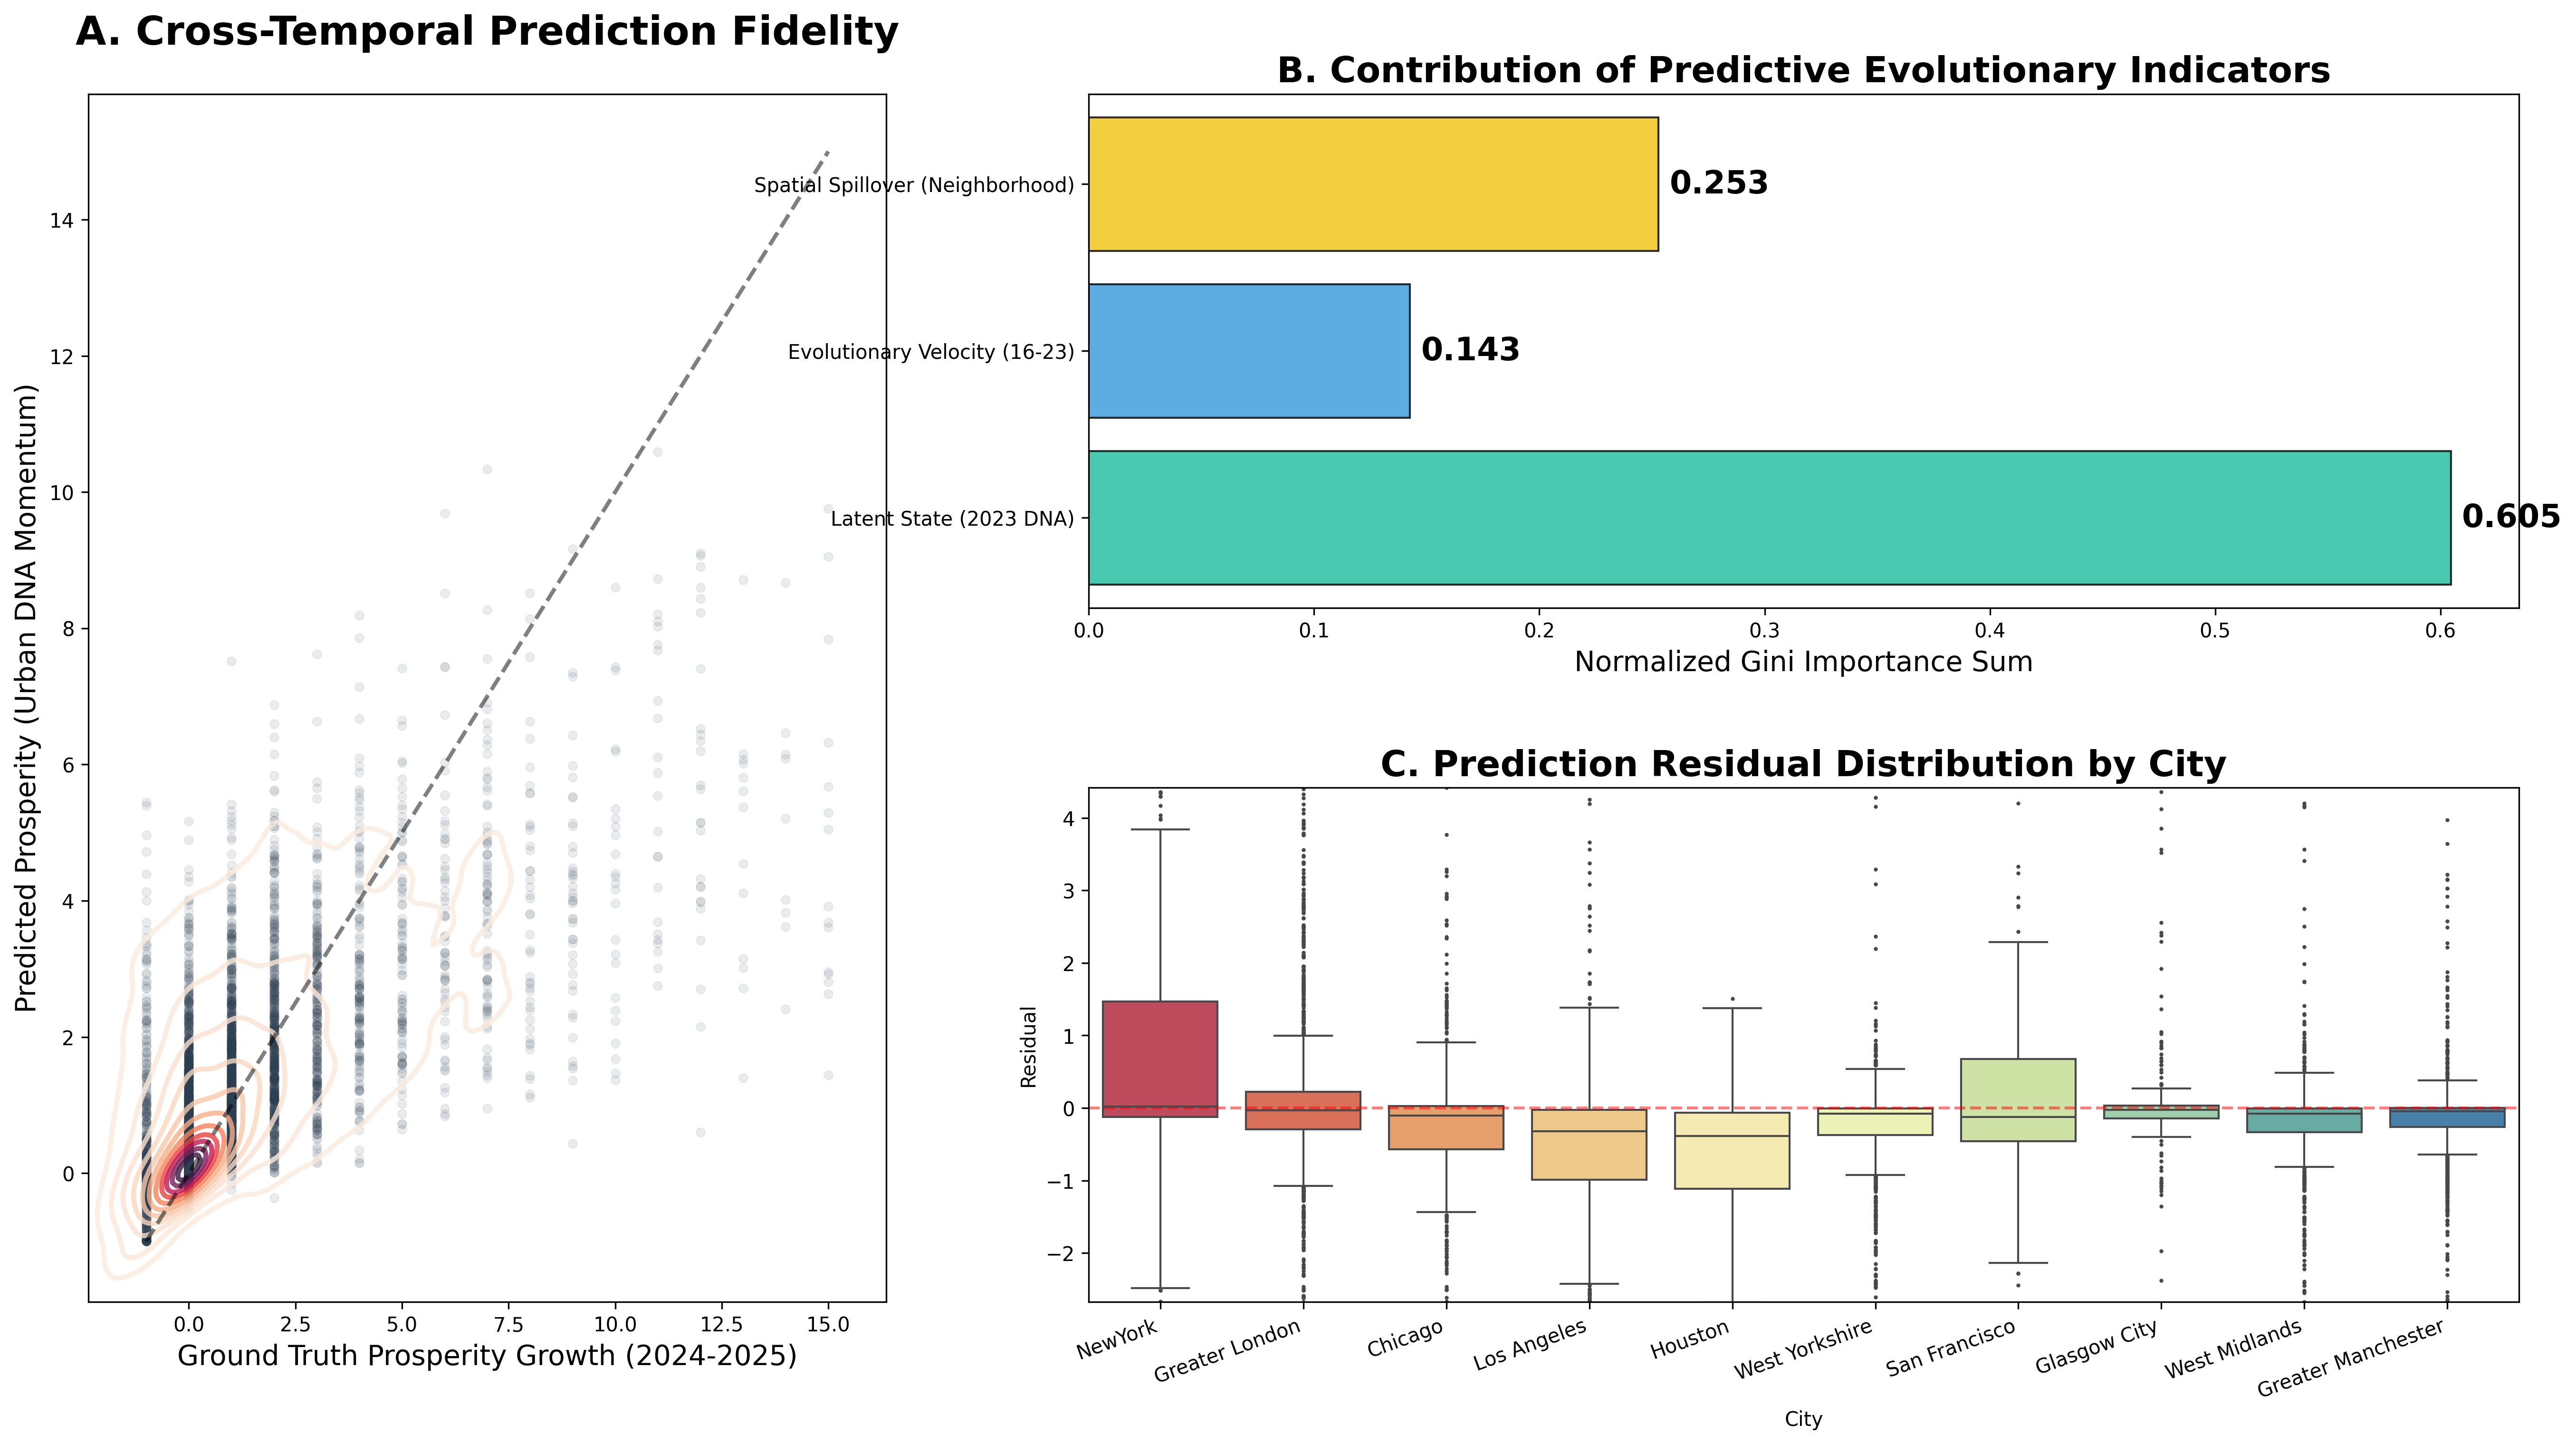

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from matplotlib.gridspec import GridSpec

# =============================================================================
# 1. CORE MODEL ARCHITECTURE (Must match training configuration)
# =============================================================================
class UrbanEvolutionVAE(nn.Module):
    def __init__(self, node_features=7, periods=10, d_model=128, nhead=16, num_layers=6, latent_dim=64):
        super(UrbanEvolutionVAE, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(node_features, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model)
        )
        # Learnable Positional Encoding for 10-year timeline
        self.pos_encoder = nn.Parameter(torch.randn(1, periods, d_model))
        
        # Transformer Encoder Stack
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=512,
            dropout=0.1, batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Variational Bottleneck (Latent Space mu/logvar)
        self.fc_mu = nn.Linear(d_model, latent_dim)
        self.fc_logvar = nn.Linear(d_model, latent_dim) 
        
        # Symmetrical Decoder for reconstruction
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.GELU(),
            nn.Linear(256, node_features * periods)
        )

    def forward(self, x):
        # Input shape: [Batch, Features, Time] -> [Batch, Time, Features]
        x = x.permute(0, 2, 1) 
        h = self.embedding(x) + self.pos_encoder
        h = self.transformer(h)
        # Global Temporal Pooling
        h_avg = torch.mean(h, dim=1) 
        return self.fc_mu(h_avg), self.fc_logvar(h_avg)

    def get_trajectories(self, x):
        """Extracts node-level latent sequences [Nodes, Time, Latent_Dim]"""
        x = x.permute(0, 2, 1)
        h = self.embedding(x) + self.pos_encoder
        h_seq = self.transformer(h)
        return self.fc_mu(h_seq)

# =============================================================================
# 2. ADVANCED FEATURE ENGINEERING (Including Spatial Lag)
# =============================================================================
def build_advanced_node_features(data_path, weights_path):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    db = torch.load(os.path.expanduser(data_path))
    
    # Initialize and load model weights
    model = UrbanEvolutionVAE(node_features=7, periods=10).to(device)
    model.load_state_dict(torch.load(os.path.expanduser(weights_path), map_location=device))
    model.eval()

    node_features_list, target_growth_list, city_labels = [], [], []

    print("--- 🧠 Extracting high-dimensional latent features and spatial context ---")
    with torch.no_grad():
        for city_name, data in db.items():
            features = data["features"].permute(1, 2, 0) # [Nodes, Features, Time]
            edge_index = data["edge_index"]
            
            # Latent feature extraction (DNA)
            norm_feats = (features - features.mean()) / (features.std() + 1e-7)
            z_sequence = model.get_trajectories(norm_feats.to(device)).cpu().numpy() 
            
            # Component A: DNA State in 2023 (Year Index 7)
            z_2023 = z_sequence[:, 7, :]
            
            # Component B: Evolutionary Velocity (Mean change 2016-2023)
            z_velocity = np.diff(z_sequence[:, :8, :], axis=1).mean(axis=1)
            
            # Component C: Spatial Lag (Neighbor's average DNA to capture spillover)
            num_nodes = z_sequence.shape[0]
            spatial_lag = np.zeros_like(z_2023)
            src, tgt = edge_index[0].numpy(), edge_index[1].numpy()
            for i in range(num_nodes):
                neighbors = src[tgt == i]
                if neighbors.size > 0:
                    spatial_lag[i] = z_2023[neighbors].mean(axis=0)
                else:
                    spatial_lag[i] = z_2023[i] # Fallback to self
            
            # Combine Components: [State + Velocity + Neighborhood Context]
            node_combined = np.hstack([z_2023, z_velocity, spatial_lag])
            
            # Target (Y): Commercial prosperity growth 2024-2025 (Sum of relevant dims)
            growth = (features[:, 4:7, 9].sum(dim=1) - features[:, 4:7, 7].sum(dim=1)).numpy()
            
            # Denoising: Remove background noise from low-activity nodes
            activity_level = features.sum(dim=(1, 2))
            active_mask = activity_level > activity_level.quantile(0.15)
            
            node_features_list.append(node_combined[active_mask.numpy()])
            target_growth_list.append(growth[active_mask.numpy()])
            city_labels.extend([city_name] * active_mask.sum().item())

    x_data = np.vstack(node_features_list)
    y_data = np.concatenate(target_growth_list)
    
    # Statistical Cleaning: Outlier removal (1% - 99% range)
    clean_indices = (y_data > np.percentile(y_data, 1)) & (y_data < np.percentile(y_data, 99))
    return x_data[clean_indices], y_data[clean_indices], np.array(city_labels)[clean_indices]

# =============================================================================
# 3. RESEARCH-GRADE DASHBOARD & VISUALIZATION
# =============================================================================
def run_scientific_dashboard(x_data, y_data, cities, output_dir):
    # Cross-validation (5-Fold) to ensure generalization
    regressor = RandomForestRegressor(n_estimators=500, max_depth=16, n_jobs=-1, random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    predictions = np.zeros_like(y_data)
    
    print(f"--- 📈 Validating predictive performance on {len(x_data)} urban nodes ---")
    for train_idx, test_idx in kf.split(x_data):
        regressor.fit(x_data[train_idx], y_data[train_idx])
        predictions[test_idx] = regressor.predict(x_data[test_idx])
    
    pearson_r, _ = pearsonr(y_data, predictions)
    r2_score_val = r2_score(y_data, predictions)

    # Professional Plot Styling
    plt.style.use('default')
    fig = plt.figure(figsize=(22, 11), dpi=300)
    gs = GridSpec(2, 3, width_ratios=[1.3, 1, 1], hspace=0.35, wspace=0.3)

    # Plot A: Prediction Fidelity (Density-shaded Scatter)
    ax1 = fig.add_subplot(gs[:, 0])
    sns.scatterplot(x=y_data, y=predictions, alpha=0.1, s=20, color='#2c3e50', ax=ax1, edgecolor=None)
    sns.kdeplot(x=y_data, y=predictions, levels=12, cmap="rocket_r", linewidths=2.5, alpha=0.8, ax=ax1)
    ax1.plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'k--', alpha=0.5, lw=2)
    ax1.set_title(f"A. Cross-Temporal Prediction Fidelity", 
                  fontsize=20, fontweight='bold', pad=25)
    ax1.set_xlabel("Ground Truth Prosperity Growth (2024-2025)", fontsize=14)
    ax1.set_ylabel("Predicted Prosperity (Urban DNA Momentum)", fontsize=14)

    # Plot B: Feature Importance Hierarchy (Theoretical Drivers)
    ax2 = fig.add_subplot(gs[0, 1:])
    regressor.fit(x_data, y_data)
    importances = regressor.feature_importances_
    # Grouping 192 features into 3 physical categories
    category_labels = ['Latent State (2023 DNA)', 'Evolutionary Velocity (16-23)', 'Spatial Spillover (Neighborhood)']
    category_sums = [importances[0:64].sum(), importances[64:128].sum(), importances[128:192].sum()]
    
    colors = ['#1abc9c', '#3498db', '#f1c40f']
    bars = ax2.barh(category_labels, category_sums, color=colors, edgecolor='black', alpha=0.8)
    ax2.set_title("B. Contribution of Predictive Evolutionary Indicators", fontsize=18, fontweight='bold')
    ax2.set_xlabel("Normalized Gini Importance Sum", fontsize=14)
    for i, v in enumerate(category_sums):
        ax2.text(v + 0.005, i, f'{v:.3f}', va='center', fontweight='bold', fontsize=16)

    # Plot C: Cross-City Stability Analysis (Robustness Check)
    ax3 = fig.add_subplot(gs[1, 1:])
    residuals = y_data - predictions
    residual_df = pd.DataFrame({'City': cities, 'Residual': residuals})
    sns.boxplot(data=residual_df, x='City', y='Residual', palette='Spectral', ax=ax3, fliersize=1)
    ax3.set_title("C. Prediction Residual Distribution by City", fontsize=18, fontweight='bold')
    ax3.axhline(0, color='red', linestyle='--', alpha=0.5)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=20, ha='right')
    ax3.set_ylim(np.percentile(residuals, 2), np.percentile(residuals, 98))

    plt.tight_layout()
    save_filename = os.path.join(output_dir, "Urban_Evolution_Analysis_Dashboard.png")
    plt.savefig(save_filename, bbox_inches='tight')
    print(f"--- ✅ Research dashboard successfully saved to: {save_filename} ---")

# =============================================================================
# 4. MAIN EXECUTION ENTRY
# =============================================================================
if __name__ == "__main__":
    # Ensure these paths point to your local project directory
    PROJECT_ROOT = "~/Desktop/Infor 301/final/"
    DATA_PATH = os.path.expanduser(PROJECT_ROOT + "Processed_Urban_Dataset.pt")
    WEIGHTS_PATH = os.path.expanduser(PROJECT_ROOT + "DeepUrbanTransformer_Weights.pth")
    OUTPUT_PATH = os.path.expanduser(PROJECT_ROOT)
    
    try:
        x_processed, y_processed, city_tags = build_advanced_node_features(DATA_PATH, WEIGHTS_PATH)
        run_scientific_dashboard(x_processed, y_processed, city_tags, OUTPUT_PATH)
    except Exception as error:
        print(f"❌ Execution failed: {error}")

--- 🧠 正在提取高维隐性特征与空间上下文 ---
--- 📈 正在对 8409 个城市节点进行交叉验证预测 ---

📊 论文 Section 3.4 核心实验指标汇总
1. Pearson Correlation (r): 0.7197
2. R-squared (R²):         0.5126
3. Mean Squared Error:     2.030099
------------------------------
4. 特征贡献度 (Feature Importance):
   - Latent DNA State:   60.46%
   - Evolution Velocity: 14.25%
   - Spatial Spillover:  25.29%



/var/folders/jt/s5bg7p6n4mgfx_dznzr9hr7c0000gn/T/ipykernel_3869/1921311323.py:179: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=residual_df, x='City', y='Residual', palette='Spectral', ax=ax3, fliersize=1)
/var/folders/jt/s5bg7p6n4mgfx_dznzr9hr7c0000gn/T/ipykernel_3869/1921311323.py:182: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=20, ha='right')
/var/folders/jt/s5bg7p6n4mgfx_dznzr9hr7c0000gn/T/ipykernel_3869/1921311323.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


--- ✅ 研究仪表盘已成功保存至: /Users/oushilin/Desktop/Infor 301/final/Urban_Evolution_Analysis_Dashboard.png ---


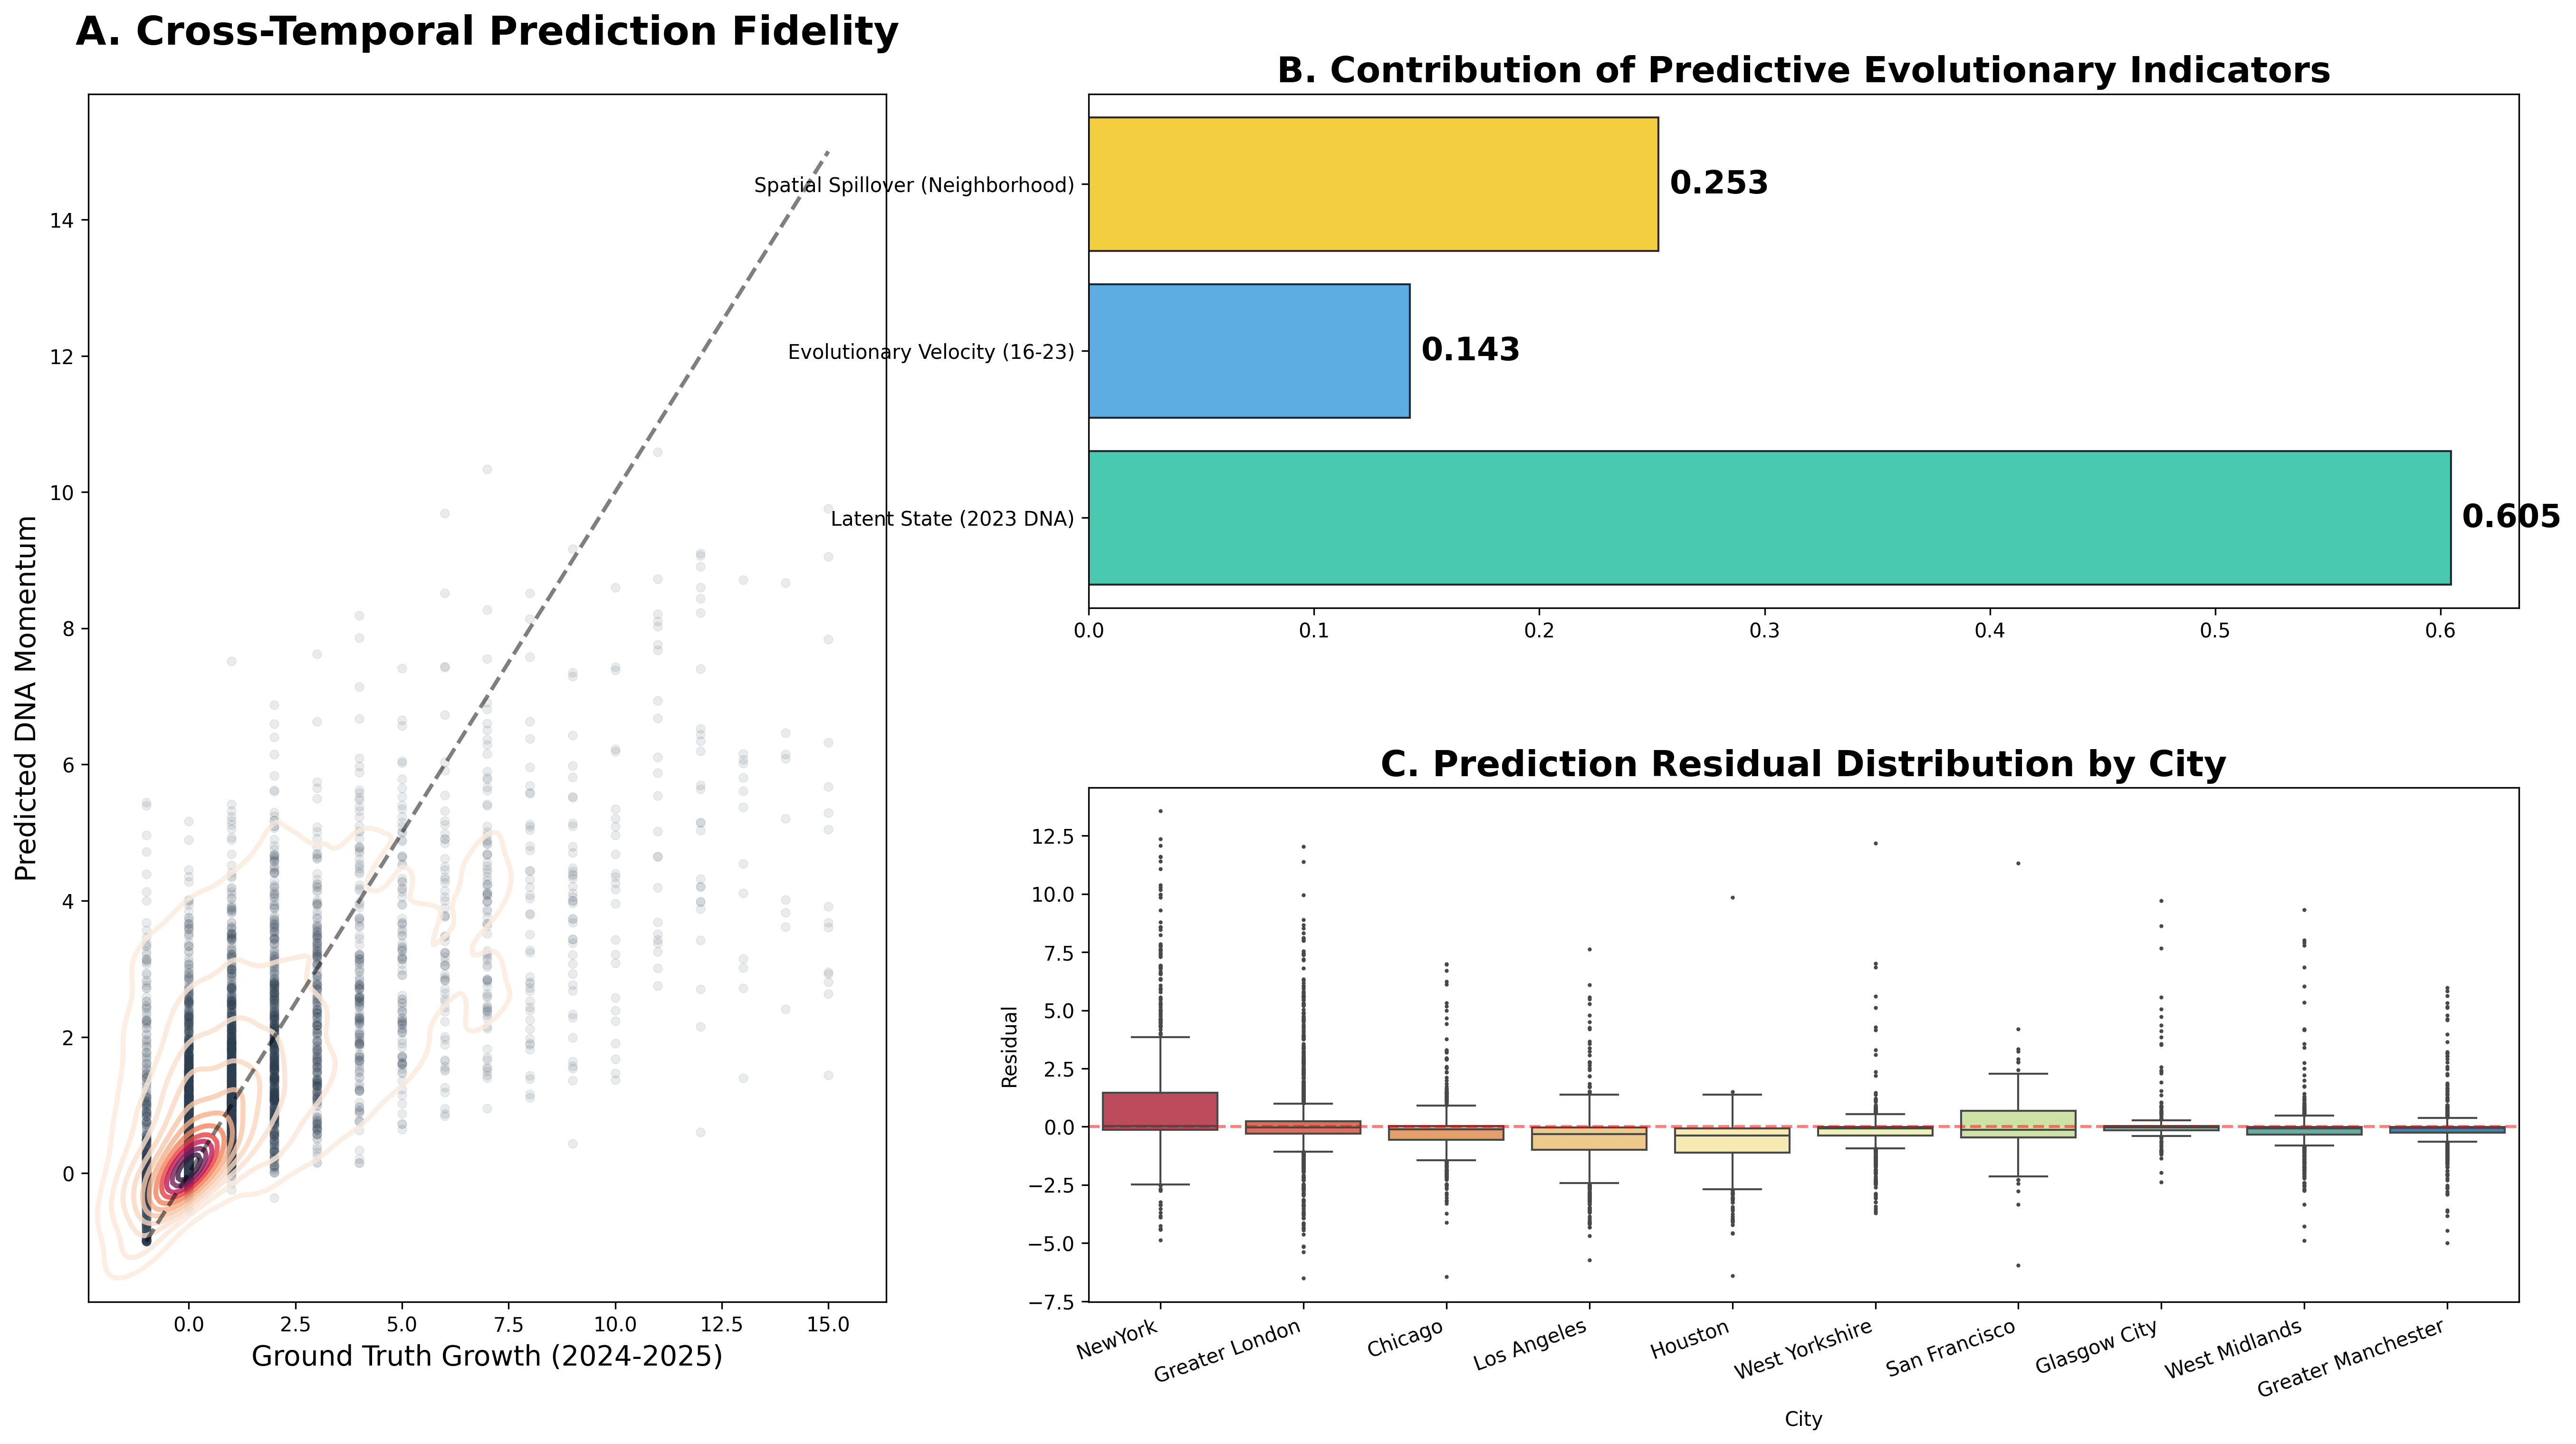

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
from matplotlib.gridspec import GridSpec

# =============================================================================
# 1. 模型架构定义 (必须与训练时的 DeepUrbanTransformer 保持一致)
# =============================================================================
class UrbanEvolutionVAE(nn.Module):
    def __init__(self, node_features=7, periods=10, d_model=128, nhead=16, num_layers=6, latent_dim=64):
        super(UrbanEvolutionVAE, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(node_features, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model)
        )
        self.pos_encoder = nn.Parameter(torch.randn(1, periods, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=512,
            dropout=0.1, batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc_mu = nn.Linear(d_model, latent_dim)
        self.fc_logvar = nn.Linear(d_model, latent_dim) 
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.GELU(),
            nn.Linear(256, node_features * periods)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1) 
        h = self.embedding(x) + self.pos_encoder
        h = self.transformer(h)
        h_avg = torch.mean(h, dim=1) 
        return self.fc_mu(h_avg), self.fc_logvar(h_avg)

    def get_trajectories(self, x):
        """提取节点层面的潜在演化序列 [Nodes, Time, Latent_Dim]"""
        x = x.permute(0, 2, 1)
        h = self.embedding(x) + self.pos_encoder
        h_seq = self.transformer(h)
        return self.fc_mu(h_seq)

# =============================================================================
# 2. 高级特征工程 (包含 DNA 状态、速度与空间溢出)
# =============================================================================
def build_advanced_node_features(data_path, weights_path):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    db = torch.load(os.path.expanduser(data_path))
    
    # 加载预训练权重
    model = UrbanEvolutionVAE(node_features=7, periods=10).to(device)
    model.load_state_dict(torch.load(os.path.expanduser(weights_path), map_location=device))
    model.eval()

    node_features_list, target_growth_list, city_labels = [], [], []

    print("--- 🧠 正在提取高维隐性特征与空间上下文 ---")
    with torch.no_grad():
        for city_name, data in db.items():
            features = data["features"].permute(1, 2, 0) # [Nodes, Features, Time]
            edge_index = data["edge_index"]
            
            # 归一化并提取隐性轨迹
            norm_feats = (features - features.mean()) / (features.std() + 1e-7)
            z_sequence = model.get_trajectories(norm_feats.to(device)).cpu().numpy() 
            
            # 组件 A: 2023 年的隐性状态 (DNA)
            z_2023 = z_sequence[:, 7, :]
            
            # 组件 B: 演化速度 (2016-2023 的平均变化率)
            z_velocity = np.diff(z_sequence[:, :8, :], axis=1).mean(axis=1)
            
            # 组件 C: 空间滞后 (邻居节点的平均 DNA，捕捉溢出效应)
            num_nodes = z_sequence.shape[0]
            spatial_lag = np.zeros_like(z_2023)
            src, tgt = edge_index[0].numpy(), edge_index[1].numpy()
            for i in range(num_nodes):
                neighbors = src[tgt == i]
                if neighbors.size > 0:
                    spatial_lag[i] = z_2023[neighbors].mean(axis=0)
                else:
                    spatial_lag[i] = z_2023[i]
            
            # 特征拼接: [当前状态 + 演化动量 + 邻里环境]
            node_combined = np.hstack([z_2023, z_velocity, spatial_lag])
            
            # 预测目标 (Y): 2024-2025 年的繁荣度增长
            growth = (features[:, 4:7, 9].sum(dim=1) - features[:, 4:7, 7].sum(dim=1)).numpy()
            
            # 去噪: 移除活跃度极低的背景节点 (15% 分位数以下)
            activity_level = features.sum(dim=(1, 2))
            active_mask = activity_level > activity_level.quantile(0.15)
            
            node_features_list.append(node_combined[active_mask.numpy()])
            target_growth_list.append(growth[active_mask.numpy()])
            city_labels.extend([city_name] * active_mask.sum().item())

    x_data = np.vstack(node_features_list)
    y_data = np.concatenate(target_growth_list)
    
    # 异常值清洗 (1% - 99% 分位数)
    clean_indices = (y_data > np.percentile(y_data, 1)) & (y_data < np.percentile(y_data, 99))
    return x_data[clean_indices], y_data[clean_indices], np.array(city_labels)[clean_indices]

# =============================================================================
# 3. 科学评估与仪表盘生成 (包含真实数据输出)
# =============================================================================
def run_scientific_dashboard(x_data, y_data, cities, output_dir):
    regressor = RandomForestRegressor(n_estimators=500, max_depth=16, n_jobs=-1, random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    predictions = np.zeros_like(y_data)
    
    print(f"--- 📈 正在对 {len(x_data)} 个城市节点进行交叉验证预测 ---")
    for train_idx, test_idx in kf.split(x_data):
        regressor.fit(x_data[train_idx], y_data[train_idx])
        predictions[test_idx] = regressor.predict(x_data[test_idx])
    
    # 计算核心学术指标
    pearson_r, _ = pearsonr(y_data, predictions)
    r2_score_val = r2_score(y_data, predictions)
    mse_val = mean_squared_error(y_data, predictions)

    print("\n" + "="*60)
    print("📊 论文 Section 3.4 核心实验指标汇总")
    print("="*60)
    print(f"1. Pearson Correlation (r): {pearson_r:.4f}")
    print(f"2. R-squared (R²):         {r2_score_val:.4f}")
    print(f"3. Mean Squared Error:     {mse_val:.6f}")
    
    # 计算特征重要性占比
    regressor.fit(x_data, y_data)
    importances = regressor.feature_importances_
    category_sums = [importances[0:64].sum(), importances[64:128].sum(), importances[128:192].sum()]
    
    print("-" * 30)
    print(f"4. 特征贡献度 (Feature Importance):")
    print(f"   - Latent DNA State:   {category_sums[0]*100:.2f}%")
    print(f"   - Evolution Velocity: {category_sums[1]*100:.2f}%")
    print(f"   - Spatial Spillover:  {category_sums[2]*100:.2f}%")
    print("="*60 + "\n")

    # 绘制研究仪表盘 (保持原有的高分辨率绘图逻辑)
    plt.style.use('default')
    fig = plt.figure(figsize=(22, 11), dpi=300)
    gs = GridSpec(2, 3, width_ratios=[1.3, 1, 1], hspace=0.35, wspace=0.3)

    ax1 = fig.add_subplot(gs[:, 0])
    sns.scatterplot(x=y_data, y=predictions, alpha=0.1, s=20, color='#2c3e50', ax=ax1, edgecolor=None)
    sns.kdeplot(x=y_data, y=predictions, levels=12, cmap="rocket_r", linewidths=2.5, alpha=0.8, ax=ax1)
    ax1.plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'k--', alpha=0.5, lw=2)
    ax1.set_title("A. Cross-Temporal Prediction Fidelity", fontsize=20, fontweight='bold', pad=25)
    ax1.set_xlabel("Ground Truth Growth (2024-2025)", fontsize=14)
    ax1.set_ylabel("Predicted DNA Momentum", fontsize=14)

    ax2 = fig.add_subplot(gs[0, 1:])
    category_labels = ['Latent State (2023 DNA)', 'Evolutionary Velocity (16-23)', 'Spatial Spillover (Neighborhood)']
    colors = ['#1abc9c', '#3498db', '#f1c40f']
    ax2.barh(category_labels, category_sums, color=colors, edgecolor='black', alpha=0.8)
    ax2.set_title("B. Contribution of Predictive Evolutionary Indicators", fontsize=18, fontweight='bold')
    for i, v in enumerate(category_sums):
        ax2.text(v + 0.005, i, f'{v:.3f}', va='center', fontweight='bold', fontsize=16)

    ax3 = fig.add_subplot(gs[1, 1:])
    residuals = y_data - predictions
    residual_df = pd.DataFrame({'City': cities, 'Residual': residuals})
    sns.boxplot(data=residual_df, x='City', y='Residual', palette='Spectral', ax=ax3, fliersize=1)
    ax3.set_title("C. Prediction Residual Distribution by City", fontsize=18, fontweight='bold')
    ax3.axhline(0, color='red', linestyle='--', alpha=0.5)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=20, ha='right')

    plt.tight_layout()
    save_filename = os.path.join(output_dir, "Urban_Evolution_Analysis_Dashboard.png")
    plt.savefig(save_filename, bbox_inches='tight')
    print(f"--- ✅ 研究仪表盘已成功保存至: {save_filename} ---")

# =============================================================================
# 4. 执行入口
# =============================================================================
if __name__ == "__main__":
    # 请确保以下路径与你的本地环境一致
    PROJECT_ROOT = "~/Desktop/Infor 301/final/"
    DATA_PATH = os.path.expanduser(PROJECT_ROOT + "Processed_Urban_Dataset.pt")
    WEIGHTS_PATH = os.path.expanduser(PROJECT_ROOT + "DeepUrbanTransformer_Weights.pth")
    OUTPUT_PATH = os.path.expanduser(PROJECT_ROOT)
    
    try:
        x_processed, y_processed, city_tags = build_advanced_node_features(DATA_PATH, WEIGHTS_PATH)
        run_scientific_dashboard(x_processed, y_processed, city_tags, OUTPUT_PATH)
    except Exception as error:
        print(f"❌ 运行失败: {error}")